       fecha   abrir     max     min  cerrar  cierre_ajustado   volumen  \
0 2014-09-17  359.55  361.47  351.59  355.96           355.96  16389166   
1 2014-09-18  355.59  355.51  319.79  328.54           328.54  26691849   
2 2014-09-19  328.28  330.94  298.92  307.76           307.76  29560103   
3 2014-09-20  307.67  329.98  303.93  318.76           318.76  28736826   
4 2014-09-21  318.12  321.50  306.50  310.63           310.63  20702625   

   retorno_log_diario  media_movil_7d  media_movil_30d  volatilidad_7d  \
0                 NaN             NaN              NaN             NaN   
1           -0.080160             NaN              NaN             NaN   
2           -0.065338             NaN              NaN             NaN   
3            0.035118             NaN              NaN             NaN   
4           -0.025836             NaN              NaN             NaN   

   volatilidad_30d  prediccion  
0              NaN    313.3062  
1              NaN    318.4001  
2    

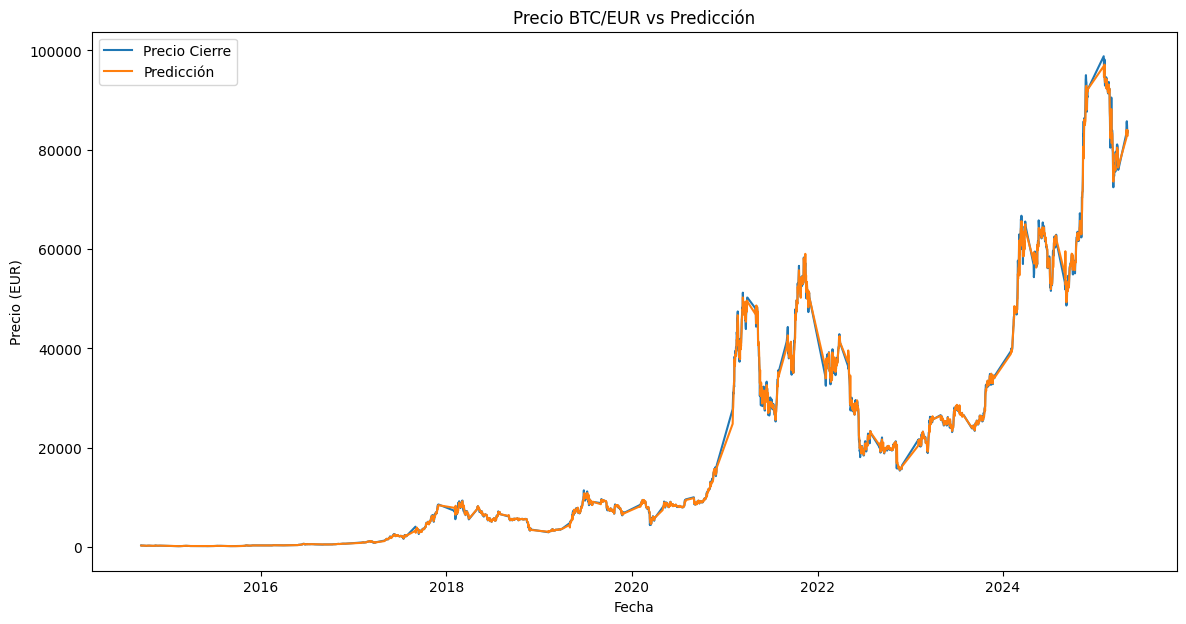

In [57]:
# Paso 1: Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



# Paso 2: Cargar el dataframe desde la ruta correcta
df = pd.read_csv('BTC_EUR_data_predicciones.csv', parse_dates=['fecha'])

# Revisar las primeras filas para asegurarnos que se cargó bien
print(df.head())

# También revisar info general del dataframe
print(df.info())

# Paso 3: Visualización inicial
plt.figure(figsize=(14,7))
plt.plot(df['fecha'], df['cerrar'], label='Precio Cierre')
plt.plot(df['fecha'], df['prediccion'], label='Predicción')
plt.xlabel('Fecha')
plt.ylabel('Precio (EUR)')
plt.title('Precio BTC/EUR vs Predicción')
plt.legend()
plt.show()

Paso 1: Ver si la serie es estacionaria (Test ADF)

La hipótesis nula es que no es estacionaria.

In [58]:
# Serie temporal que queremos analizar
serie = df['cierre_ajustado'].dropna()

# Test ADF
resultado_adf = adfuller(serie)
print('ADF Statistic:', resultado_adf[0])
print('p-value:', resultado_adf[1])
for key, value in resultado_adf[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -1.9090520067433456
p-value: 0.32781481682525637
Critical Value 1%: -3.4320456867492983
Critical Value 5%: -2.8622892614314974
Critical Value 10%: -2.5671688411269202


El p-valor es 0.327, mayor que 0.05, lo que significa que no podemos rechazar la hipótesis nula.
Esto indica que la serie no es estacionaria.

- Descomponer la serie diferenciada

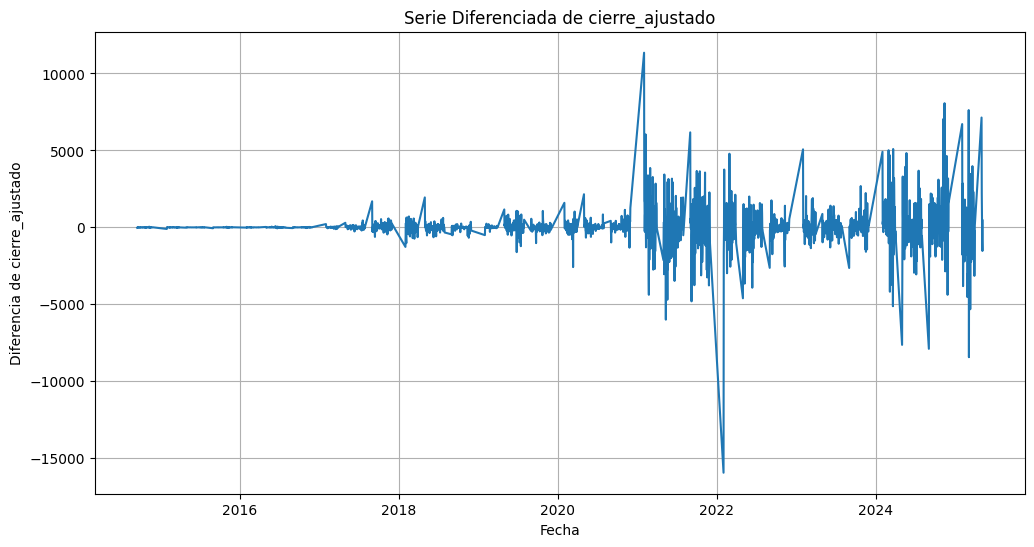

ADF Statistic (diferenciada): -12.47867626738109
p-value: 3.126646964492434e-23
Critical Value 1%: -3.4320456867492983
Critical Value 5%: -2.8622892614314974
Critical Value 10%: -2.5671688411269202


In [59]:
# Diferenciar la serie de cierre_ajustado para hacerla estacionaria
df['diferencia'] = df['cierre_ajustado'].diff()

# Visualizar la serie diferenciada
plt.figure(figsize=(12,6))
plt.plot(df['fecha'], df['diferencia'])
plt.title('Serie Diferenciada de cierre_ajustado')
plt.xlabel('Fecha')
plt.ylabel('Diferencia de cierre_ajustado')
plt.grid(True)
plt.show()

# Realizar nuevamente el Test ADF
resultado_adf_diff = adfuller(df['diferencia'].dropna())
print(f'ADF Statistic (diferenciada): {resultado_adf_diff[0]}')
print(f'p-value: {resultado_adf_diff[1]}')
for key, value in resultado_adf_diff[4].items():
    print(f'Critical Value {key}: {value}')

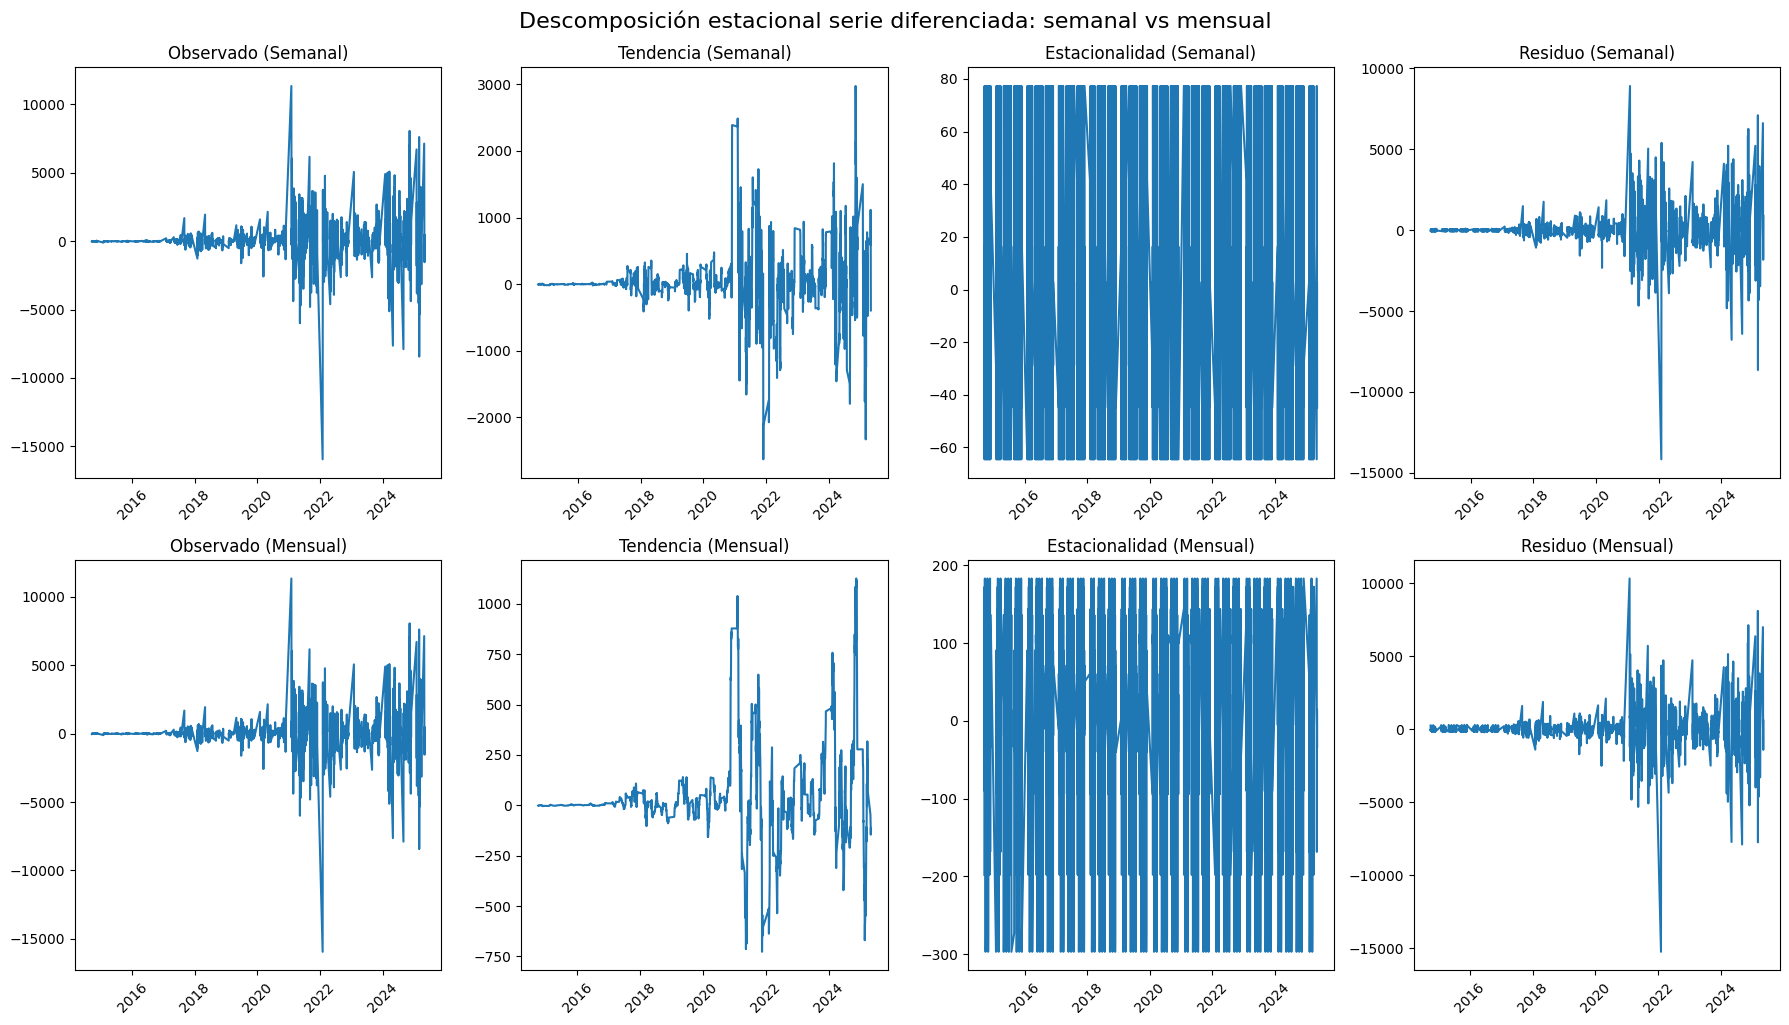

In [60]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Asegurar que el índice sea datetime para descomposición correcta
df = df.set_index('fecha')

# Tomar la serie diferenciada para estacionarizar
serie_diff = df['cierre_ajustado'].diff().dropna()

# Descomposición semanal (period=7)
result_semanal = seasonal_decompose(serie_diff, model='additive', period=7)

# Descomposición mensual (period=30)
result_mensual = seasonal_decompose(serie_diff, model='additive', period=30)

# Graficar resultados lado a lado
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Semana
axes[0, 0].plot(result_semanal.observed)
axes[0, 0].set_title('Observado (Semanal)')
axes[0, 1].plot(result_semanal.trend)
axes[0, 1].set_title('Tendencia (Semanal)')
axes[0, 2].plot(result_semanal.seasonal)
axes[0, 2].set_title('Estacionalidad (Semanal)')
axes[0, 3].plot(result_semanal.resid)
axes[0, 3].set_title('Residuo (Semanal)')

# Mes
axes[1, 0].plot(result_mensual.observed)
axes[1, 0].set_title('Observado (Mensual)')
axes[1, 1].plot(result_mensual.trend)
axes[1, 1].set_title('Tendencia (Mensual)')
axes[1, 2].plot(result_mensual.seasonal)
axes[1, 2].set_title('Estacionalidad (Mensual)')
axes[1, 3].plot(result_mensual.resid)
axes[1, 3].set_title('Residuo (Mensual)')

for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Descomposición estacional serie diferenciada: semanal vs mensual', fontsize=16, y=1.02)
plt.show()

Conclusiones:

El ciclo semanal muestra más ruido en tendencia y residuos y
El ciclo mensual revela mejor la tendencia y la estacionalidad más estable.

In [61]:
print(df.columns)

Index(['abrir', 'max', 'min', 'cerrar', 'cierre_ajustado', 'volumen',
       'retorno_log_diario', 'media_movil_7d', 'media_movil_30d',
       'volatilidad_7d', 'volatilidad_30d', 'prediccion', 'diferencia'],
      dtype='object')


<Figure size 1200x400 with 0 Axes>

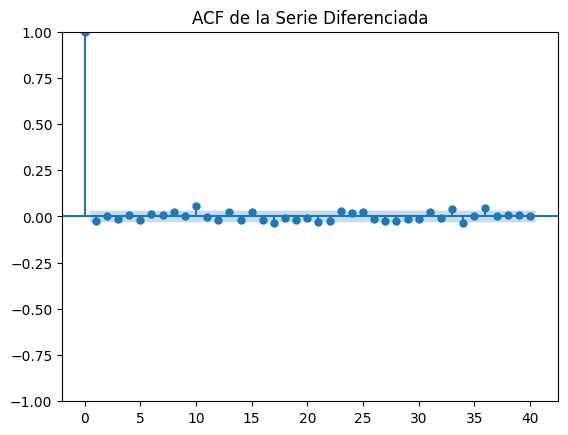

<Figure size 1200x400 with 0 Axes>

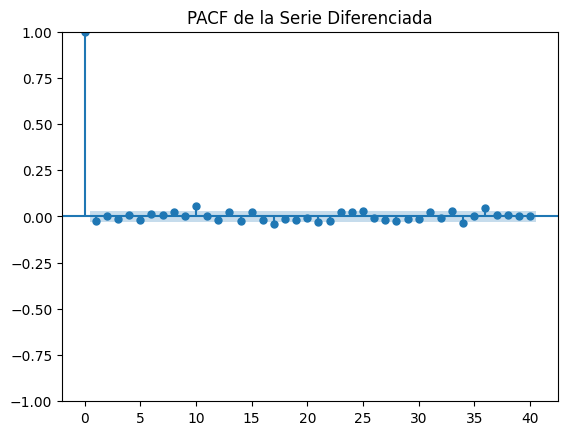

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dat

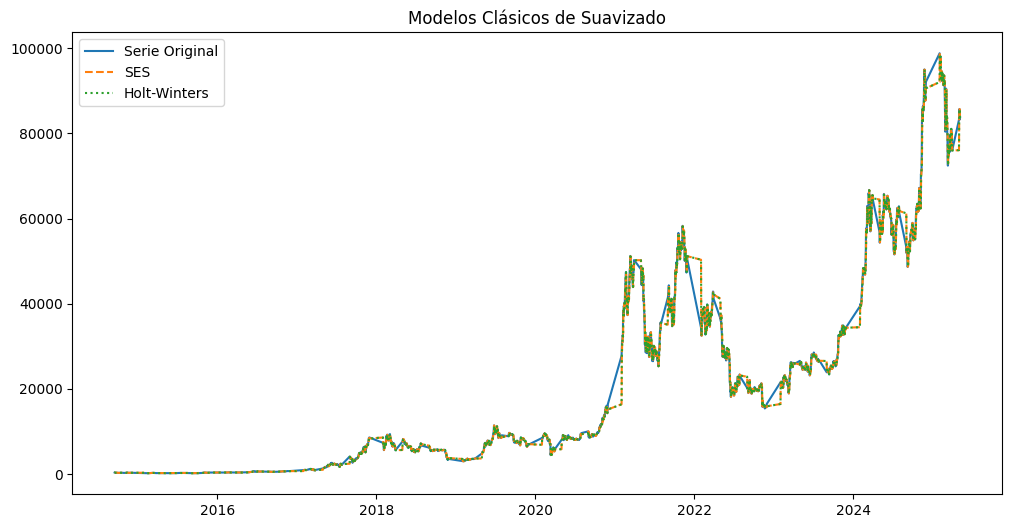

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dat

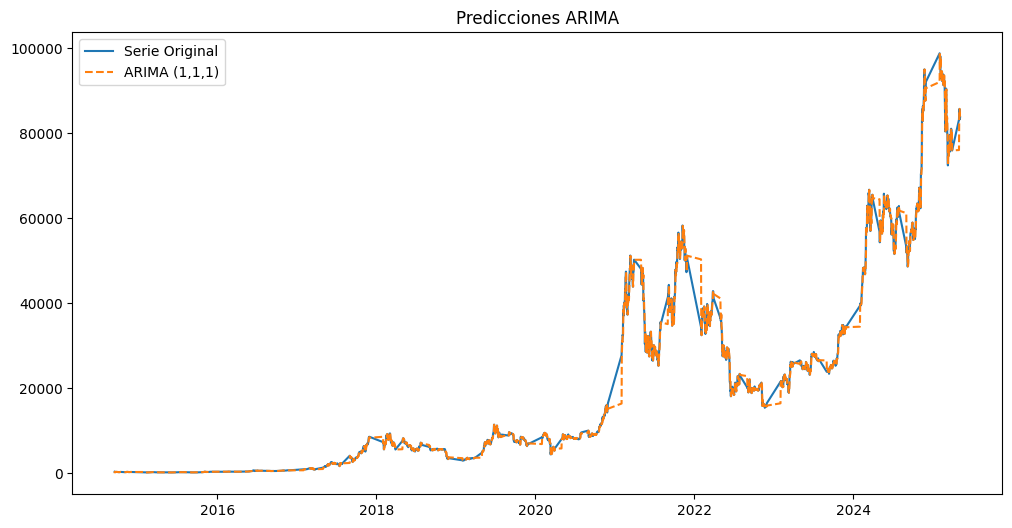

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dat

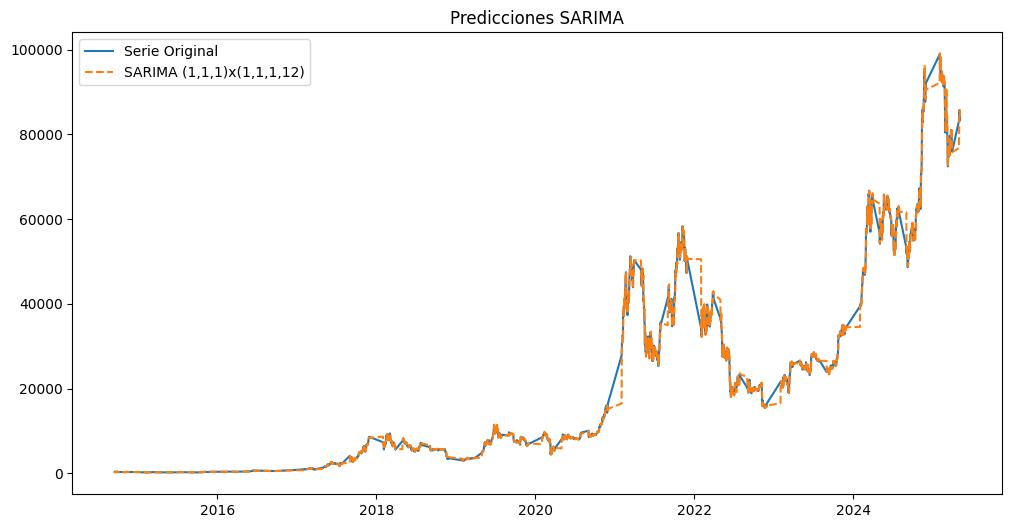

--- SES ---
MSE: 2064964.74
RMSE: 1437.00
MAE: 515.14

--- Holt-Winters ---
MSE: 2065621.41
RMSE: 1437.23
MAE: 515.86

--- ARIMA ---
MSE: 2065389.03
RMSE: 1437.15
MAE: 515.09

--- SARIMA ---
MSE: 2148040.80
RMSE: 1465.62
MAE: 541.80


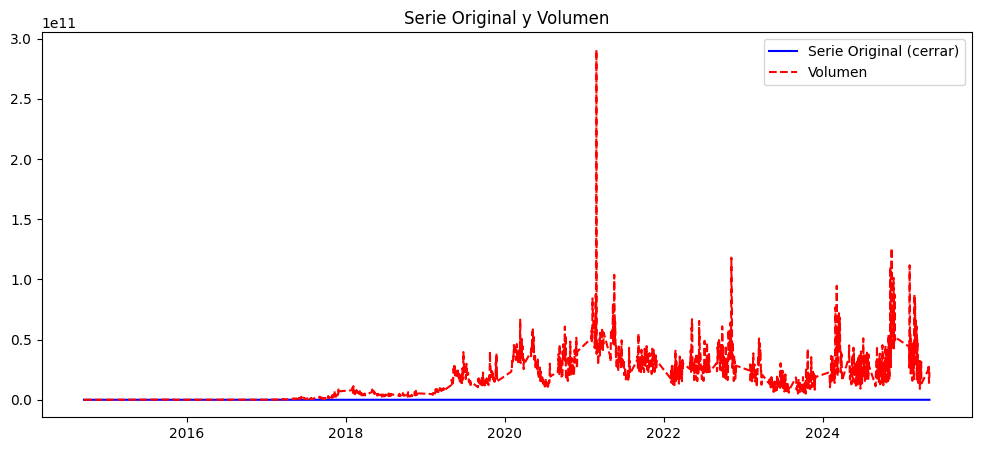

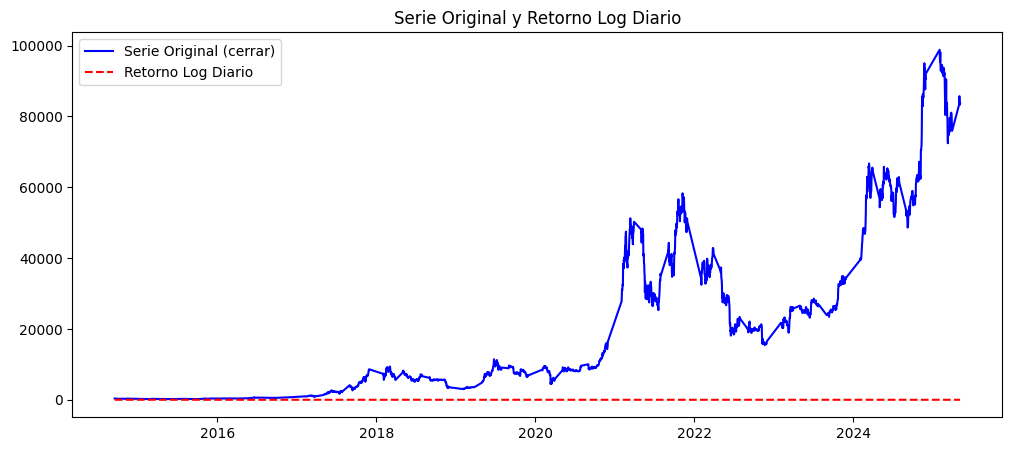

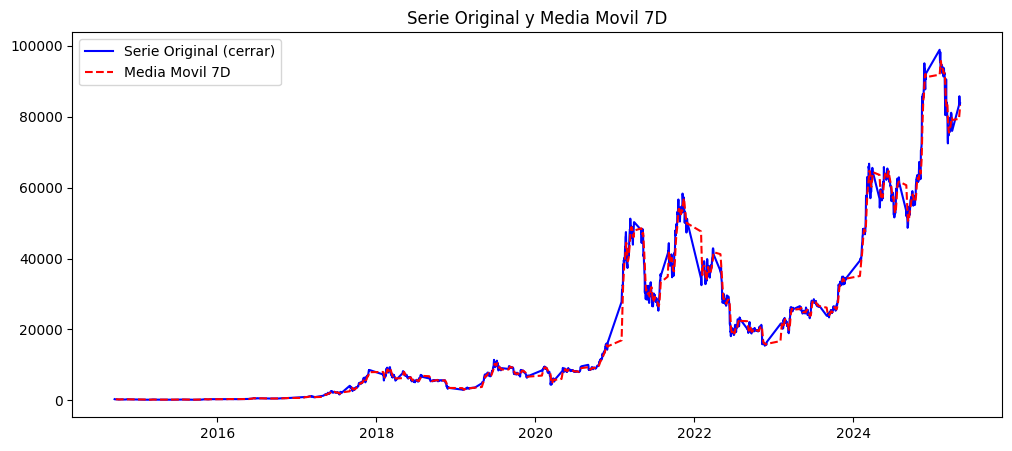

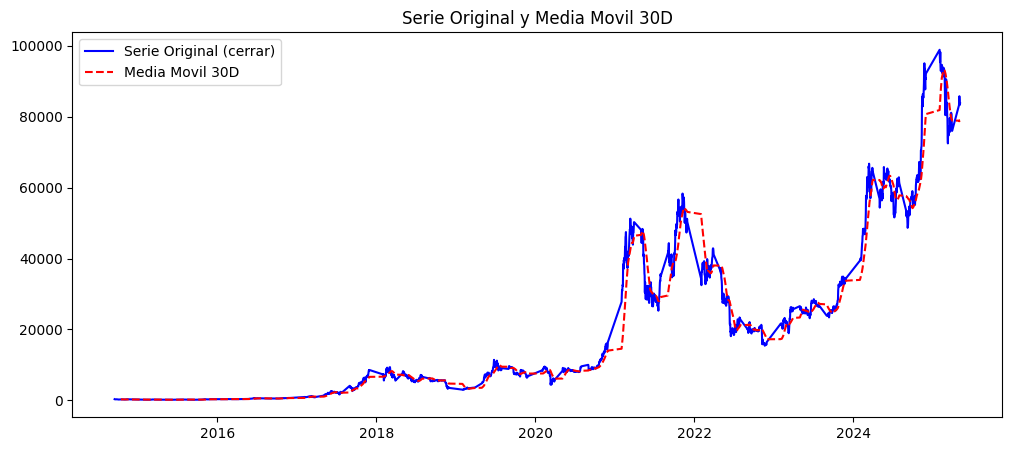

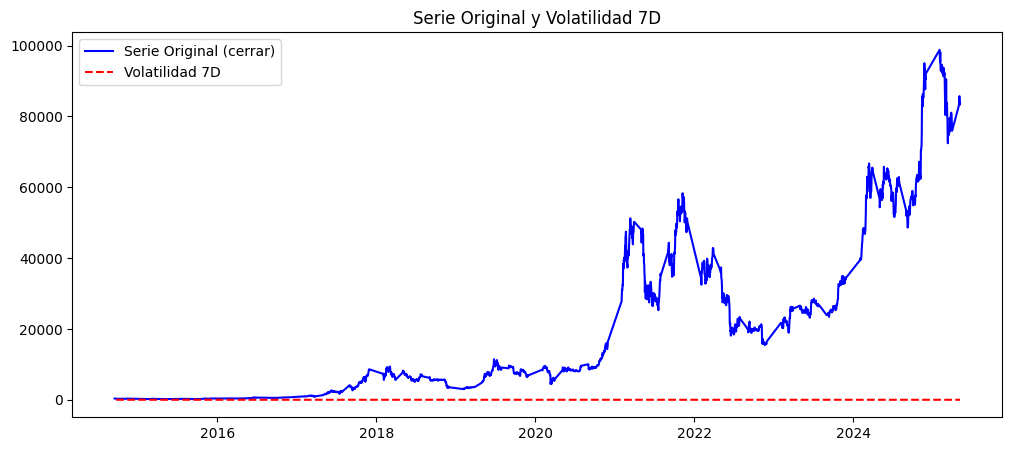

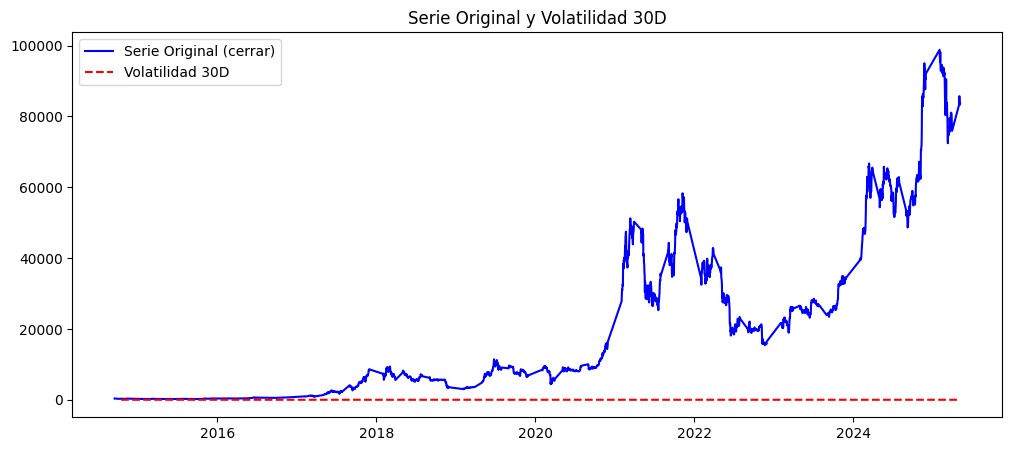

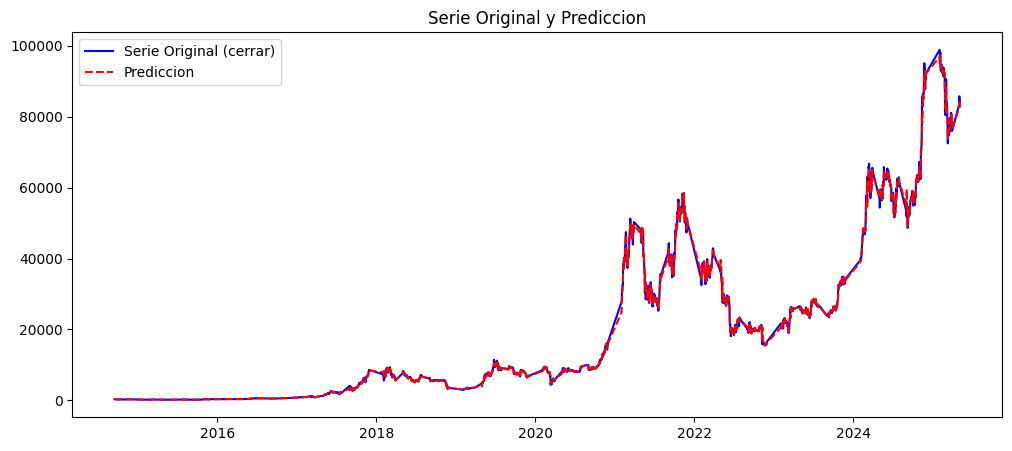

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

In [64]:
# Asegúrate que el índice sea datetime
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Serie
serie = df['cerrar']

# Paso 4: Serie diferenciada para ACF y PACF
serie_diff = serie.diff().dropna()

plt.figure(figsize=(12, 4))
plot_acf(serie_diff, lags=40)
plt.title('ACF de la Serie Diferenciada')
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(serie_diff, lags=40, method='ywm')
plt.title('PACF de la Serie Diferenciada')
plt.show()

# Paso 5: Modelos clásicos de suavizado

modelo_ses = SimpleExpSmoothing(serie).fit()
predicciones_ses = modelo_ses.fittedvalues

modelo_hw = ExponentialSmoothing(serie, seasonal_periods=12, trend='add', seasonal='add').fit()
predicciones_hw = modelo_hw.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie, label='Serie Original')
plt.plot(predicciones_ses.index, predicciones_ses, label='SES', linestyle='--')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle=':')
plt.legend()
plt.title('Modelos Clásicos de Suavizado')
plt.show()

# Paso 6: Modelos ARIMA/SARIMA

modelo_arima = ARIMA(serie, order=(1, 1, 1)).fit()
predicciones_arima = modelo_arima.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie, label='Serie Original')
plt.plot(predicciones_arima.index, predicciones_arima, label='ARIMA (1,1,1)', linestyle='--')
plt.legend()
plt.title('Predicciones ARIMA')
plt.show()

modelo_sarima = SARIMAX(serie, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
predicciones_sarima = modelo_sarima.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie, label='Serie Original')
plt.plot(predicciones_sarima.index, predicciones_sarima, label='SARIMA (1,1,1)x(1,1,1,12)', linestyle='--')
plt.legend()
plt.title('Predicciones SARIMA')
plt.show()

# Paso 7: Validación

def evaluar_modelo(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAE: {mae:.2f}')

print('--- SES ---')
evaluar_modelo(serie, predicciones_ses)
print('\n--- Holt-Winters ---')
evaluar_modelo(serie, predicciones_hw)
print('\n--- ARIMA ---')
evaluar_modelo(serie[1:], predicciones_arima[1:])
print('\n--- SARIMA ---')
evaluar_modelo(serie[1:], predicciones_sarima[1:])

# Paso 8: KPIs

# Lista de KPIs que quieres graficar junto con la serie original 'cerrar'
kpis = ['volumen', 'retorno_log_diario', 'media_movil_7d', 'media_movil_30d', 
        'volatilidad_7d', 'volatilidad_30d', 'prediccion']

for kpi in kpis:
    if kpi in df.columns:
        plt.figure(figsize=(12, 5))
        plt.plot(serie.index, serie, label='Serie Original (cerrar)', color='blue')
        plt.plot(df.index, df[kpi], label=kpi.replace('_', ' ').title(), color='red', linestyle='--')
        plt.title(f'Serie Original y {kpi.replace("_", " ").title()}')
        plt.legend()
        plt.show()

plt.figure(figsize=(14, 8))

